In [18]:
# CLAIM: Many of the Prodigal-predicted ORFs are likely spurious. 

In [4]:
import pandas as pd 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import src.tools as tools
import glob
from src.files import FASTAFile, InterProScanFile
from src.reference import annotate
from scipy.stats import chisquare
from utils import * 

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
get_percent = lambda n, total : f'{100 * n / total:.2f}%' if (total > 0) else '0%'
is_top_hit_hypothetical = lambda df : df.top_hit_product == 'hypothetical protein'

In [6]:
dataset_df = pd.read_csv('../data/results/results-2/dataset.csv', index_col=0)
dataset_df = annotate(dataset_df)

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 
dataset_df = dataset_df[~dataset_df.genome_id.isin(exclude_genome_ids)].copy()

In [ ]:
print('Num. matches with a significant alignment:', is_aligned(match_df).sum(), f'({get_percent(is_aligned(match_df).sum(), len(match_df))})')
print('Num. hypothetical matches with a significant alignment:', (is_aligned(match_df) & is_top_hit_hypothetical(match_df)).sum(), f'({get_percent((is_aligned(match_df) & is_top_hit_hypothetical(match_df)).sum(), is_top_hit_hypothetical(match_df).sum())})')
print('Num. annotated matches with a significant alignment:', (is_aligned(match_df) & ~is_top_hit_hypothetical(match_df)).sum(), f'({get_percent((is_aligned(match_df) & ~is_top_hit_hypothetical(match_df)).sum(), (~is_top_hit_hypothetical(match_df)).sum())})')

Num. matches with a significant alignment: 31713 (64.17%)
Num. hypothetical matches with a significant alignment: 360 (4.58%)
Num. annotated matches with a significant alignment: 31353 (75.43%)


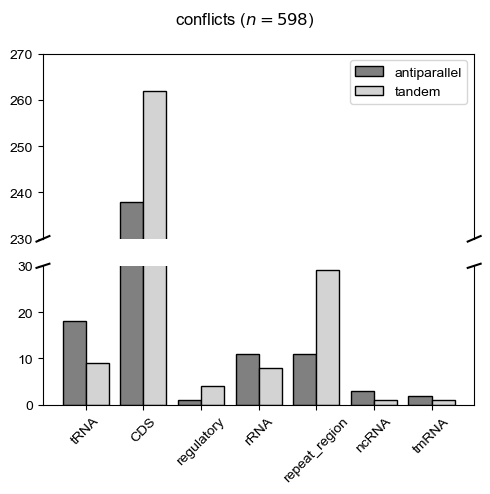

In [ ]:
def figure(dataset_df:pd.DataFrame, width:float=0.4):

    figure_df = dataset_df[dataset_df.conflict].copy()
    figure_df['top_hit_product'] = np.where(figure_df.top_hit_pseudo, 'pseudogene', figure_df.top_hit_product)
    figure_df['category'] = figure_df.top_hit_feature


    fig, axes = get_split_axes((0, 30), (230, 270))
    
    offsets = {True:width/2, False:-width/2}
    palette = {True:'lightgray', False:'gray'}
        
    positions = np.arange(figure_df.category.nunique())

    for same_strand, df in figure_df.groupby('same_strand'):
        ax_df = pd.DataFrame(index=figure_df.category.unique())
        ax_df['count'] = df.category.value_counts()
        axes[0].bar(positions + offsets[same_strand], ax_df['count'], color=palette[same_strand], edgecolor='black', width=width, label='tandem' if same_strand else 'antiparallel')
        axes[1].bar(positions + offsets[same_strand], ax_df['count'], color=palette[same_strand], edgecolor='black', width=width)

    axes[1].set_xticks(positions, labels=figure_df.category.unique(), rotation=45)
    axes[0].legend()

    # text = ''
    # for category, df in figure_df.groupby('category'):
    #     text += '$p_{' + category + '}$' + f' = {get_percent(len(df), len(figure_df))} ($n={len(df)}$)\n'
    # ax_a.text(0.4, 0.6, text, transform=ax_a.transAxes, fontsize='small')

    fig.suptitle(f'conflicts ($n={len(figure_df)}$)')
    fig.tight_layout()
    plt.show()

figure(dataset_df)

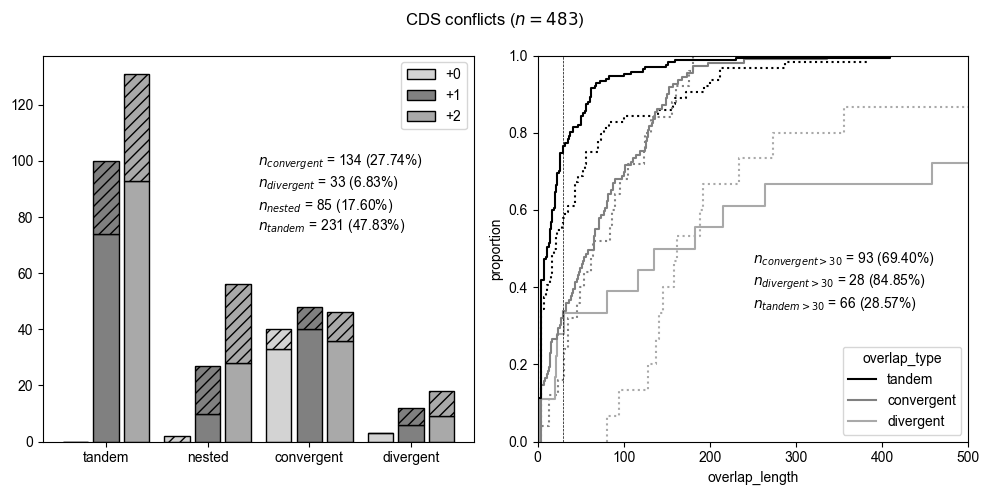

In [11]:
# TODO: Not sure if it's worth including the phases in the bar plot. 

def figure(dataset_df:pd.DataFrame, exclude_nested:bool=False):
    figure_df = dataset_df[is_cds_conflict(dataset_df)].copy()
    # figure_df = figure_df[figure_df.overlap_type != 'nested'].copy() if exclude_nested else figure_df
    
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    # figure_df['phase'] = ['none' if (row.overlap_type == 'nested') else '+' + str(int(row.phase)) for row in figure_df.itertuples()]
    figure_df['phase'] = ['+' + str(int(row.phase)) for row in figure_df.itertuples()]
    figure_df['hypothetical'] = is_top_hit_hypothetical(figure_df)

    palette = {'+0':'lightgray', '+1':'gray', '+2':'darkgray', 'none':'white'}
    offsets = {'+0':-0.3, '+1':0, '+2':0.3, 'none':0}
    overlap_types = figure_df.overlap_type.unique()
    positions = np.arange(len(overlap_types))
    width = 0.25

    def panel_a(ax_df:pd.DataFrame, offset:float=None, color=None):
        totals =  np.zeros(len(overlap_types))
        bottom = np.zeros(len(overlap_types))
        for hypothetical, df in ax_df.groupby('hypothetical'):
            heights = [(df.overlap_type == overlap_type).sum() for overlap_type in overlap_types]
            ax_a.bar(positions + offset, heights, bottom=bottom, edgecolor='black', label=phase if (not hypothetical) else None, color=color, width=width, hatch='///' if hypothetical else None)
            bottom += np.array(heights)
            totals += heights

    for phase, df in figure_df.groupby('phase'):
        panel_a(df, color=palette[phase], offset=offsets[phase])

    text = ''
    for overlap_type, df in figure_df.groupby('overlap_type'):
        text += get_text(overlap_type, len(df), len(figure_df))
    ax_a.text(0.5, 0.5, text, transform=ax_a.transAxes)


    ax_a.set_xticks(positions, labels=overlap_types)
    ax_a.legend()

    ax_b_df = figure_df[figure_df.overlap_type != 'nested'].copy()
    palette = {'tandem':'black', 'convergent':'gray', 'divergent':'darkgray'}
    sns.ecdfplot(data=ax_b_df[is_top_hit_hypothetical(ax_b_df)], x='overlap_length', hue='overlap_type', ls=':', palette=palette, ax=ax_b)
    sns.ecdfplot(data=ax_b_df[~is_top_hit_hypothetical(ax_b_df)], x='overlap_length', hue='overlap_type', palette=palette, ax=ax_b)
    ax_b.set_xlim(xmin=0, xmax=500)
    ax_b.set_ylabel('proportion')

    overlap_length, text = 30, ''
    for overlap_type, df in ax_b_df.groupby('overlap_type'):
        text += get_text(f'{overlap_type} > {overlap_length}', (df.overlap_length > overlap_length).sum(), len(df))
    ax_b.text(0.5, 0.3, text, transform=ax_b.transAxes)
    ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

    fig.suptitle(f'CDS conflicts ($n={len(figure_df)}$)')
    fig.tight_layout()
    plt.show()

# figure(dataset_df, exclude_nested=True)
figure(dataset_df, exclude_nested=True)

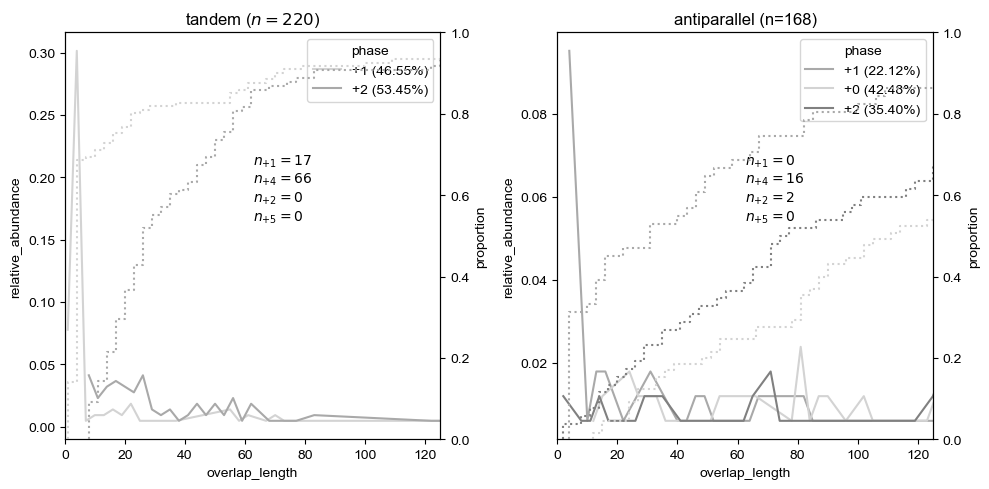

In [ ]:
# TODO: Should look at the query coverages for the overlaps with non-CDS features. 

figure_df = dataset_df[is_cds_conflict(dataset_df) & (dataset_df.overlap_type != 'nested')].copy()
figure_df['phase'] = figure_df.overlap_length % 3
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)

titles = {True:f'tandem ($n={figure_df.same_strand.sum()}$)', False:f'antiparallel ($n={(~figure_df.same_strand).sum()}$)'}

for ax, same_strand in zip(axes, [True, False]):
    ax_df = figure_df[figure_df.same_strand == same_strand].copy()
    ax_df = ax_df[ax_df.index != 'NZ_FAOO01000018.1_5'] # One of the tandem overlaps is +0 because the top hit is partial, and the query has a ton of X's in the middle.
    phase_counts = ax_df.phase.value_counts().to_dict()
    ax_df['phase'] = [f'+{phase} ({get_percent(phase_counts[phase], len(ax_df))})' for phase in ax_df.phase]

    palette = {label:['lightgray', 'darkgray', 'gray'][i] for i, label in enumerate(sorted(ax_df.phase.unique()))}
    ax_ = sns.ecdfplot(ax_df, x='overlap_length', hue='phase', palette=palette, ls=':', ax=ax.twinx(), legend=False)
    ax_.set_ylabel('proportion')

    ax_df = ax_df.overlap_length.value_counts().reset_index()
    ax_df['phase'] = ax_df.overlap_length % 3
    phase_counts = ax_df.phase.value_counts().to_dict()
    ax_df['phase'] = [f'+{phase} ({get_percent(phase_counts[phase], len(ax_df))})' for phase in ax_df.phase]
    ax_df['relative_abundance'] = ax_df['count'] / ax_df['count'].sum()
    
    palette = {label:['lightgray', 'darkgray', 'gray'][i] for i, label in enumerate(sorted(ax_df.phase.unique()))}
    sns.lineplot(ax_df, x='overlap_length', y='relative_abundance', hue='phase', palette=palette, ax=ax)

    text = ''
    for overlap_length in [1, 4, 2, 5]:
        n = ax_df[ax_df.overlap_length == overlap_length]['count']
        n = 0 if len(n) == 0 else n.iloc[0]
        text += '$n_{+' + str(overlap_length) + '} = ' + str(n) + '$\n'
    ax.text(0.5, 0.5, text, transform=ax.transAxes)
    ax.set_title(titles[same_strand])

    ax.set_xlim(xmin=0, xmax=125)

fig.tight_layout()



In [13]:
def table(dataset_df:pd.DataFrame, normalize:bool=True):

    dataset_df = dataset_df[is_cds_conflict(dataset_df) & (dataset_df.overlap_type != 'nested')].copy()
    total = len(dataset_df)

    table_df = pd.DataFrame(index=pd.Series(['tandem', 'antiparallel'], name='direction'), columns=pd.Series([0, 1, 2], name='phase'))
    for same_strand, df in dataset_df.groupby('same_strand'):
        if same_strand:
            table_df.loc['tandem', :] = df.phase.value_counts()
        else:
            table_df.loc['antiparallel', :] = df.phase.value_counts()
    table_df = table_df.infer_objects(copy=False).fillna(0)
    if normalize:
        table_df = table_df / total

    return table_df

# Frequencies from https://pmc.ncbi.nlm.nih.gov/articles/PMC525685/. Study used 64,989 overlaps to generate this table. 
ref_table_df = pd.DataFrame([[0.001, 0.259, 0.578], [0.041, 0.062, 0.060]], index=pd.Series(['tandem', 'antiparallel'], name='direction'), columns=pd.Series([0, 1, 2], name='phase'))

# The incidence of tandem overlaps in the +1 frame is significantly higher than observed in nature. 
table_df = table(dataset_df, normalize=False)
observed_counts = table_df.loc['tandem', :]
expected_counts = ref_table_df.loc['tandem', :] / ref_table_df.loc['tandem', :].sum() * observed_counts.sum()
print(f'p={chisquare(observed_counts, expected_counts).pvalue}')

# # The distribution of phase frequencies of the real-predicted proteins matches that observed in confirmed overlaps.
# table_df = table(results_df, normalize=False, exclude_spurious=True)
# observed_counts = table_df.values.ravel()
# expected_counts = (ref_table_df.values.ravel() * observed_counts.sum())
# print(f'p={chisquare(observed_counts, expected_counts, sum_check=False).pvalue}')

table_df


p=0.0002278593314510031


phase,0,1,2
direction,,,
tandem,0.0,100.0,131.0
antiparallel,43.0,60.0,64.0
